In [96]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pmdarima as pm
import seaborn as sns
from scipy import stats
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse


In [5]:
# First we need to import the data, which was given to us in .xls file we can import it via Panda
Nat_Gas = pd.read_csv("Nat_Gas.csv",index_col=0)

In [8]:
Nat_Gas.tail(10), # To see the prices over last the last 10 months

,Prices
Dates,
12/31/23,12.8
1/31/24,12.6
2/29/24,12.4
3/31/24,12.7
4/30/24,12.1
5/31/24,11.4
6/30/24,11.5
7/31/24,11.6
8/31/24,11.5


In [9]:
Nat_Gas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 48 entries, 10/31/20 to 9/30/24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Prices  48 non-null     float64
dtypes: float64(1)
memory usage: 1.8+ KB


In [10]:
Nat_Gas.describe() # In order to get the mean, the standard deviation,the quantiles, the min and the max of the prices

,Prices
count,48.000000
mean,11.207083
std,0.757897
min,9.840000
25%,10.650000
50%,11.300000
75%,11.625000
max,12.800000


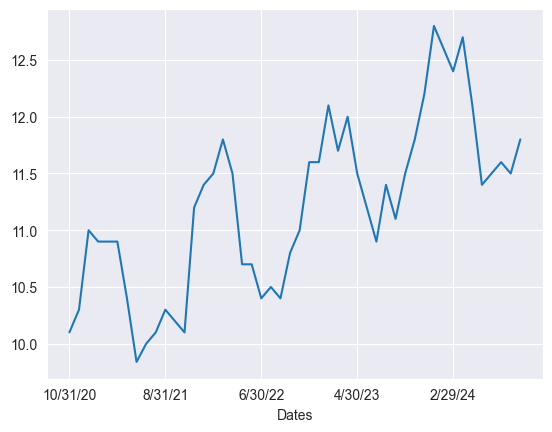

In [12]:
ax = Nat_Gas["Prices"].plot() # We'll get a graph of the evolution of the price over the months

In [14]:
# To get a better understanding and view on the evolution of the prices we'll compute the simple moving average over the last 3 months and the last 12
Nat_Gas["SMA_3"] = Nat_Gas.Prices.rolling(3).mean()
Nat_Gas["SMA_12"] = Nat_Gas.Prices.rolling(12).mean()

In [15]:
Nat_Gas # We can now compare the average price over a given amount of time to the price shown for a given month

,Prices,SMA_3,SMA_12
Dates,,,
10/31/20,10.10,NaN,NaN
11/30/20,10.30,NaN,NaN
12/31/20,11.00,10.466667,NaN
1/31/21,10.90,10.733333,NaN
2/28/21,10.90,10.933333,NaN
3/31/21,10.90,10.900000,NaN
4/30/21,10.40,10.733333,NaN
5/31/21,9.84,10.380000,NaN
6/30/21,10.00,10.080000,NaN


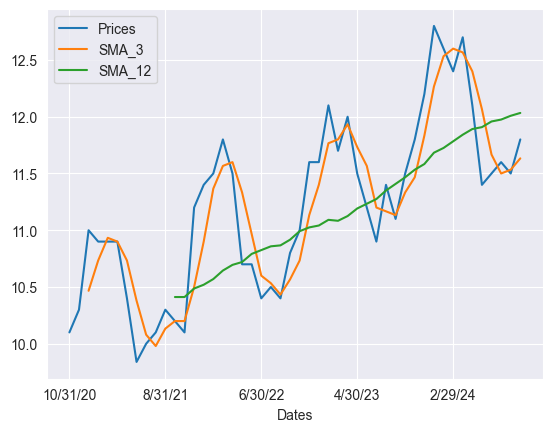

In [17]:
Nat_Gas.loc[:,["Prices","SMA_3","SMA_12"]].plot()
plt.legend(loc="upper left")
plt.show()
# We now show the evolution of the different simple moving average over time next to the prices

In [21]:
time = np.arange(1, len(Nat_Gas.index) + 1)
Nat_Gas['Time']= time
data = Nat_Gas[['Time','Prices']]
data.tail

<bound method NDFrame.tail of           Time  Prices
Dates                 
10/31/20     1   10.10
11/30/20     2   10.30
12/31/20     3   11.00
1/31/21      4   10.90
2/28/21      5   10.90
3/31/21      6   10.90
4/30/21      7   10.40
5/31/21      8    9.84
6/30/21      9   10.00
7/31/21     10   10.10
8/31/21     11   10.30
9/30/21     12   10.20
10/31/21    13   10.10
11/30/21    14   11.20
12/31/21    15   11.40
1/31/22     16   11.50
2/28/22     17   11.80
3/31/22     18   11.50
4/30/22     19   10.70
5/31/22     20   10.70
6/30/22     21   10.40
7/31/22     22   10.50
8/31/22     23   10.40
9/30/22     24   10.80
10/31/22    25   11.00
11/30/22    26   11.60
12/31/22    27   11.60
1/31/23     28   12.10
2/28/23     29   11.70
3/31/23     30   12.00
4/30/23     31   11.50
5/31/23     32   11.20
6/30/23     33   10.90
7/31/23     34   11.40
8/31/23     35   11.10
9/30/23     36   11.50
10/31/23    37   11.80
11/30/23    38   12.20
12/31/23    39   12.80
1/31/24     40   12.60
2/29

In [24]:
Nat_Gas.tail()

,Prices,SMA_3,SMA_12,Time
Dates,,,,
5/31/24,11.4,12.066667,11.908333,44
6/30/24,11.5,11.666667,11.958333,45
7/31/24,11.6,11.500000,11.975000,46
8/31/24,11.5,11.533333,12.008333,47
9/30/24,11.8,11.633333,12.033333,48


In [29]:
reg = np.polyfit(data['Time'], data['Prices'], 1)
print(f"The slope is {reg[0]} and the intercept is {reg[1]}")
# Fit a simple linear regression (degree 1 polynomial) to estimate the price trend over time; the function np.polyfit returns the coefficients [slope, intercept] of the best-fit line which correspond to the least squares

The slope is 0.03901324359531047 and the intercept is 10.251258865248227


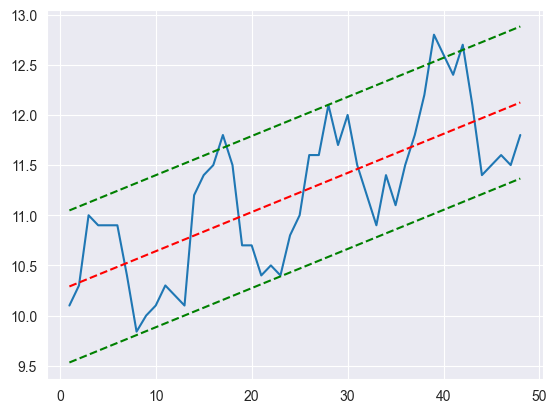

In [30]:
trend = np.polyval(reg,time)
# Evaluate the fitted linear trend line for each timestamp in the dataset
std = data["Prices"].std()
# We compute the standard deviation of prices
plt.plot(data['Time'], data['Prices'])
plt.plot(data['Time'], trend,'r--')
plt.plot(data['Time'], trend - std ,'g--')
plt.plot(data['Time'], trend + std ,'g--')
# We first plot the original price series, then the estimates linear trend, and we finish by plotting the upper and lower bands using the standard deviation
# The bands allow us to visualize how far from the trend the prices deviate

In [35]:
# In order for the plots to be readable we change the index in datetime so that the x_axis isn't considered as a number or a string poorly managed

result = seasonal_decompose(data['Prices'],model='multiplicative',period=12)
# Decompose the time series into 3 components:
# - Trend: long-term direction of the series
# - Seasonal: repeating seasonal pattern
# - Residual: what remains after removing trend and seasonality
#  model='multiplicative' means: Prices = Trend × Seasonal × Residual
# This is appropriate when seasonal fluctuations scale with the level of the series

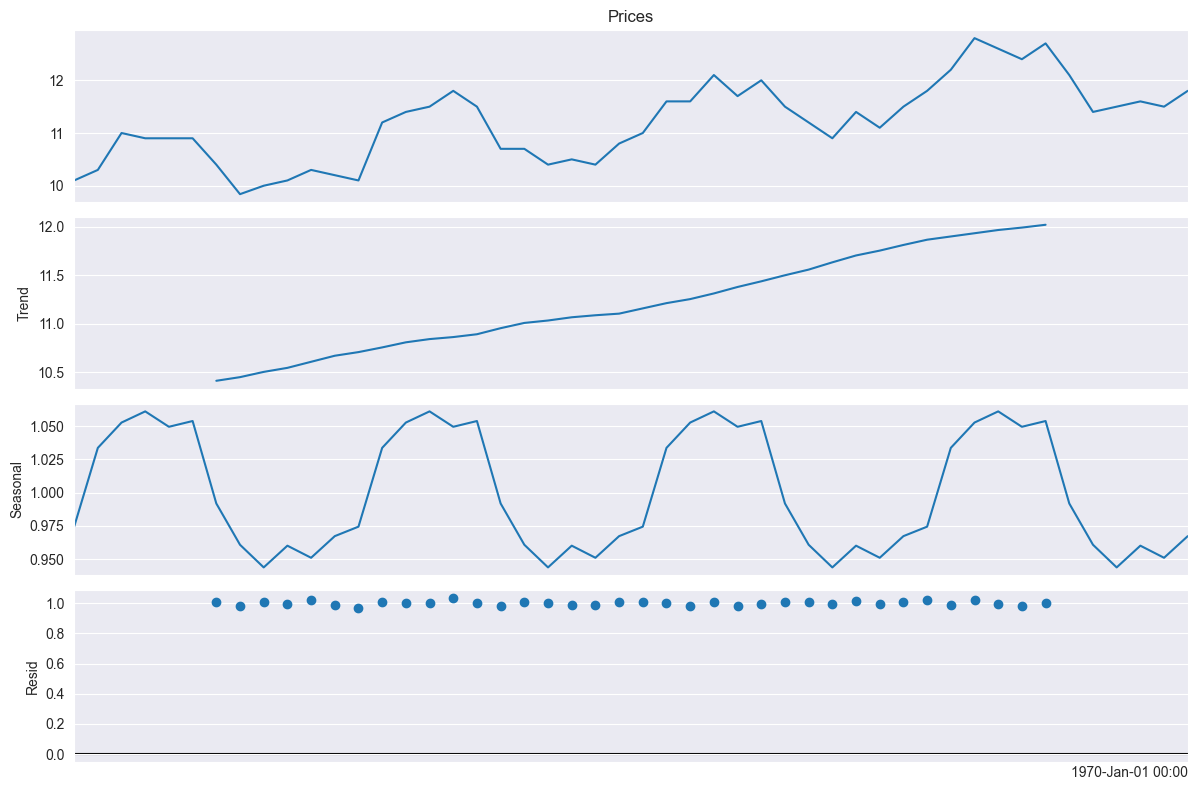

In [39]:
fig = result.plot()
fig.set_size_inches(12,8)
for ax in fig.axes:
    # We want to display less dates in order the plot to be readable
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
    ax.tick_params(axis='x', rotation= 45)

plt.tight_layout()
plt.show()

Axes(0.125,0.11;0.775x0.77)


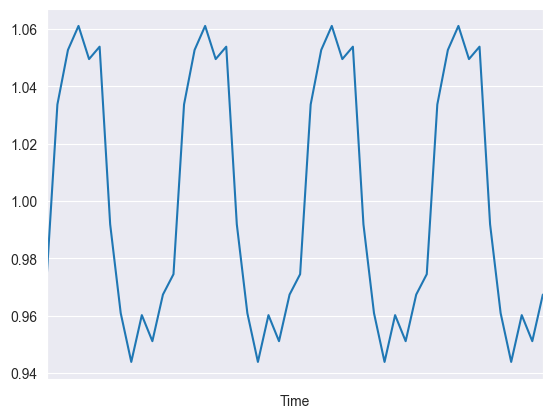

In [42]:
print(result.seasonal.plot())

Axes(0.125,0.11;0.775x0.77)


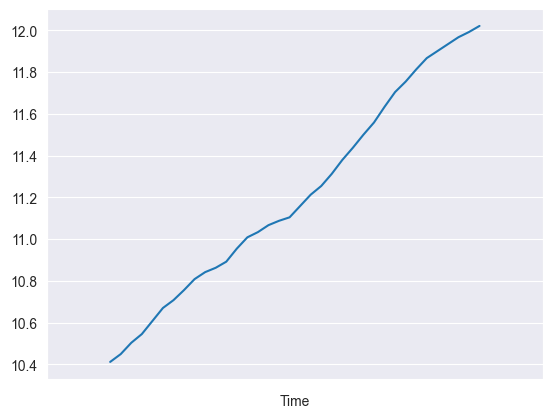

In [43]:
print(result.trend.plot())

Forecast

In [62]:
# We'll use once again the original data
Nat_Gas_df = pd.read_csv("Nat_Gas.csv")
Nat_Gas_df.head()

,Dates,Prices
0,10/31/20,10.1
1,11/30/20,10.3
2,12/31/20,11.0
3,1/31/21,10.9
4,2/28/21,10.9


In [63]:
Nat_Gas_df['Dates'] = pd.to_datetime(Nat_Gas_df['Dates'])

C:\Users\theol\AppData\Local\Temp\ipykernel_112300\1624413625.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Nat_Gas_df['Dates'] = pd.to_datetime(Nat_Gas_df['Dates'])


In [64]:
Nat_Gas_df.set_index('Dates', inplace=True)
Nat_Gas_df.head()

,Prices
Dates,
2020-10-31,10.1
2020-11-30,10.3
2020-12-31,11.0
2021-01-31,10.9
2021-02-28,10.9


<Axes: xlabel='Dates'>

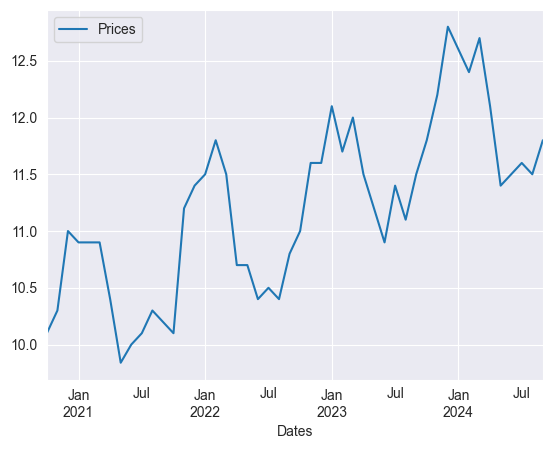

In [65]:
Nat_Gas_df.plot()

In [68]:
# We'll now test for stationary
test_result = adfuller(Nat_Gas_df['Prices'])

In [75]:
# The two hypothesis for this test are:
# - H_0 = It isn't stationary
# - H_1 = It is stationary
# Now , we define a function for the test using adfuller and that takes as an argument the Prices:
def adfuller_test(Prices):
    """
     Perform the Augmented Dickey-Fuller (ADF) test to check stationarity of a time series.

    The ADF test evaluates the null hypothesis that the time series has a unit root
    (i.e., it is non-stationary). If the p-value is below the chosen significance level
    (commonly 0.05), we reject H0 and conclude that the series is likely stationary.

    Parameters
    ----------
    Prices : array-like (pd.Series, list, np.ndarray)
        Time series values (e.g., prices). The series should contain no missing values (NaNs).

    Returns
    -------
    None
        Prints the ADF test statistic, p-value, number of lags used, and number of observations,
        as well as an interpretation of the test result at the 5% significance level.

    Notes
    -----
    - H0 (null hypothesis): the series has a unit root (non-stationary).
    - H1 (alternative hypothesis): the series has no unit root (stationary).
    """
    result = adfuller(Prices)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value, label in zip(result,labels):
        print(label+':'+str(value))
    if result[1] < 0.05:
        print("Reject H_0 due to strong evidence against it. We can deduce that the Data has no unit root and it is stationary.")
    else:
        print("Fail to reject H0: weak evidence against a unit root → the series is likely non-stationary.")


In [70]:
adfuller_test(Nat_Gas_df['Prices'])
# We run the augmented Dickey-Fuller test to check whether the price series is stationary (unit-root test)

ADF Test Statistic:0.21807686170000096
p-value:0.9732574388448694
#Lags Used:10
Number of Observations:37
We have weak evidence against H_0. The time series has no unit root and it stationary.


In [78]:
# We fit a Seasonal ARIMA (SARIMA) model to capture both:
# - the autoregressive/moving-average dynamics (p,d,q)
# - the seasonal structure repeating every 12 periods (P,D,Q with m=12)
# auto_arima searches over combinations of parameters and selects the best model according to an information criterion (typically AIC), using a stepwise approach to reduce computation time.

(pm.auto_arima(Nat_Gas_df['Prices'],seasonal = True,m=12, # yearly seasonality since the data is monthly
              max_p=7, max_d=5,max_q=7,
              max_P= 4, max_D=4,max_Q=4,
              trace=True,            # We display
              error_action='ignore',
              suppress_warnings=True,
              stepwise=True
).
summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=36.556, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=48.334, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=38.394, Time=0.08 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=42.336, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=46.741, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=39.473, Time=0.68 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=38.768, Time=0.63 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=36.266, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=53.197, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=53.566, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=53.701, Time=0.14 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=53.674, Time=0.17 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=51.953, Ti

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   48
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 -12.133
Date:                Fri, 23 Jan 2026   AIC                             36.266
Time:                        23:53:05   BIC                             47.367
Sample:                    10-31-2020   HQIC                            40.443
                         - 09-30-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0101      0.007      1.426      0.154      -0.004       0.024
ar.L1          1.6918      0.051     33.365      0.000       1.592       1.791
ar.L2         -0.9540      0.050    -19.197      0.000      -1.051      -0.857
ma.L1         -1.8012      0.228     -7.917      0.000      -2.247      -1.355
ma.L2          0.9351      0.249      3.758      0.000       0.447       1.423
sigma2         0.0900      0.028      3.267      0.001       0.036       0.144
===================================================================================
Ljung-Box (L1) (Q):                   6.09   Jarque-Bera (JB):                 2.16
Prob(Q):                              0.01   Prob(JB):                         0.34
Heteroskedasticity (H):               0.90   Skew:                             0.47
Prob(H) (two-sided):                  0.84   Kurtosis:                         2.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
# Time series train/test split, in time series we must preserve the chronological order.
train_data = Nat_Gas_df[:len(Nat_Gas_df)-12]
test_data = Nat_Gas_df[len(Nat_Gas_df)-12:]

In [83]:

arima_model = SARIMAX(train_data['Prices'],
                      order=(2,1,2), # order=(p,d,q) defines the non-seasonal part : p is the autoregressive lags, d represents the differencing and q the moving average term
                      seasonal_order=(1,1,1,12) # seasonal_order=(P,D,Q,m) defines the seasonal part with a time period m equal to 12: P the seasonal autoregressive term, D the seasonal differencing that removes seasonal pattern, Q the seasonal moving average term and m the seasonality length
                      )
# We estimate the model parameters by using the maximum likelihood
arima_result=arima_model.fit()
arima_result.summary()

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (4045278114.py, line 2)

C:\Users\theol\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


<Axes: >

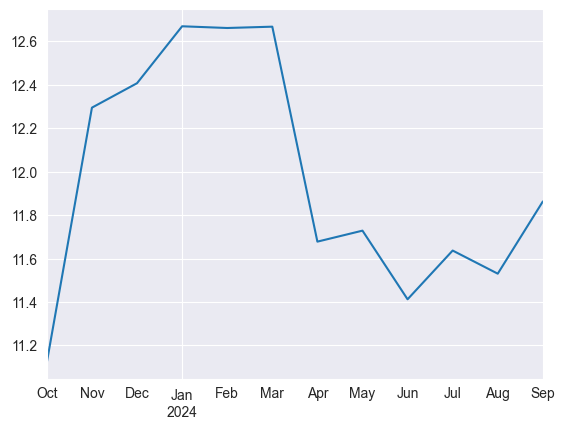

In [82]:
# Predict prices from the first index of the test set until the end of the dataset.
arima_pred = arima_result.predict(start = len(train_data), end = len(Nat_Gas_df)-1,
                                  typ='levels' # It returns predictions in the original scale
                                  ).rename("ARIMA Predictions")
arima_pred.plot()

<Axes: xlabel='Dates'>

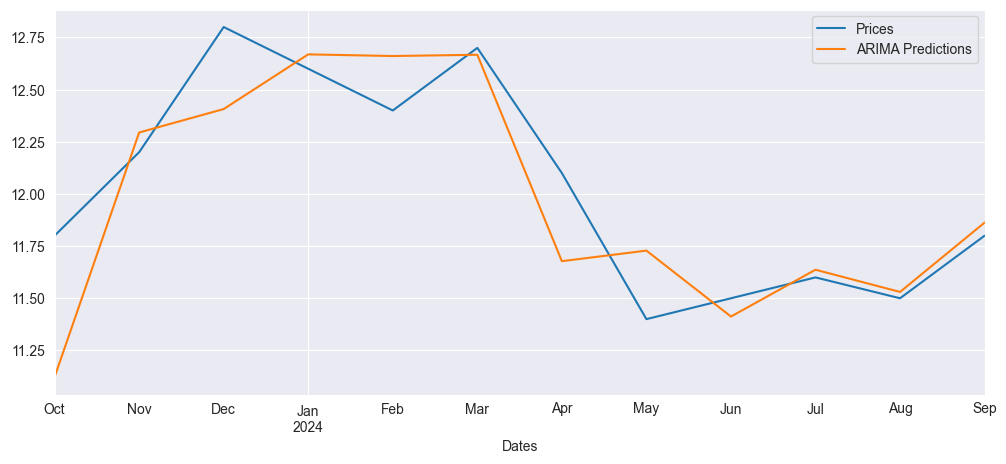

In [87]:
# We visually compare the actual prices (test set) against the ARIMA/SARIMA predictions
test_data['Prices'].plot(figsize=(12,5),legend=True)
arima_pred.plot(legend=True)

<Axes: xlabel='Dates'>

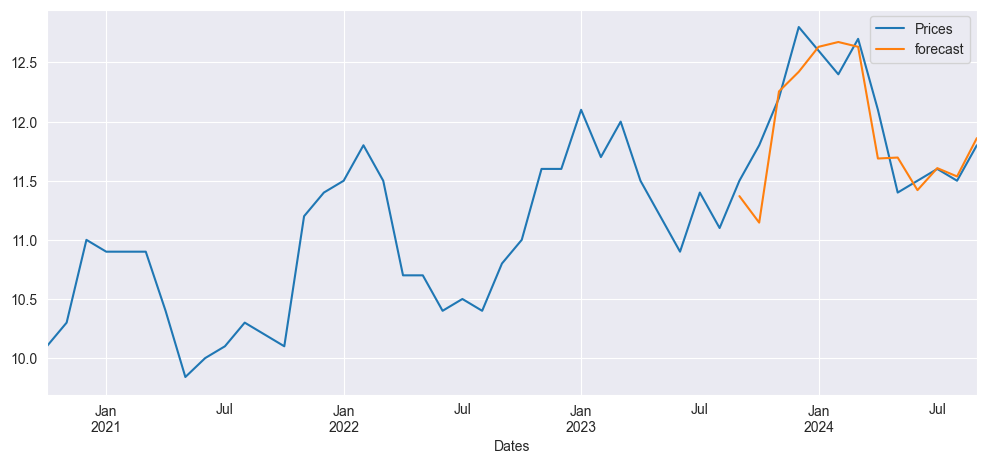

In [91]:
# We generate and store the dynamic forecasts in the dataframe
Nat_Gas_df['forecast']=arima_result.predict(start=len(Nat_Gas_df)-13,end=len(Nat_Gas_df)-1,
                                            dynamic = True # After the first forecasted point, the future predictions are based on previously forecasted values instead of the observed one
                                            )
Nat_Gas_df[['Prices','forecast']].plot(figsize=(12,5),legend=True)

In [92]:
Nat_Gas_df.tail(12)

,Prices,forecast
Dates,,
2023-10-31,11.8,11.145858
2023-11-30,12.2,12.255357
2023-12-31,12.8,12.421282
2024-01-31,12.6,12.632547
2024-02-29,12.4,12.673254
2024-03-31,12.7,12.632793
2024-04-30,12.1,11.687971
2024-05-31,11.4,11.696151
2024-06-30,11.5,11.420548


In [95]:
test_data['ARIMA Predictions']= arima_pred
test_data

C:\Users\theol\AppData\Local\Temp\ipykernel_112300\519198844.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['ARIMA Predictions']= arima_pred


,Prices,ARIMA Predictions
Dates,,
2023-10-31,11.8,11.122575
2023-11-30,12.2,12.294427
2023-12-31,12.8,12.406888
2024-01-31,12.6,12.668910
2024-02-29,12.4,12.660988
2024-03-31,12.7,12.667081
2024-04-30,12.1,11.677776
2024-05-31,11.4,11.728369
2024-06-30,11.5,11.412422


In [101]:
# RMSE measures the typical forecasting error magnitude and MSE is the squared error average
arima_rmse_error  = rmse(test_data['Prices'], arima_pred)
arima_mse_error = arima_rmse_error**2 #penalizes large errors more strongly compared to RMSE
mean_value = Nat_Gas_df['Prices'].mean() # We compute the average price level to contextualize RMSE/MSE magnitude

print(f'MSE error is {arima_mse_error}\nRMSE error is {arima_mse_error}\nMean is {mean_value}')

MSE error is 0.08302337812600094
RMSE error is 0.08302337812600094
Mean is 11.207083333333332


In [103]:
arima_pred_full = arima_result.predict(start = 0, end = len(Nat_Gas_df)-1, type = 'levels').rename("ARIMA Predictions")
# It'll allow us to visually inspect how well the model fits historical prices

C:\Users\theol\PycharmProjects\PythonProject\.venv\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['type']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [108]:
# We will now test our predictions and compare it to the actual price
S_Date = '2024-07-31'
print(f'The prediction is {arima_pred_full.loc[S_Date]}\n'
      f'The actual price is {Nat_Gas_df.loc[S_Date]['Prices']}')

The prediction is 11.636765552874545
The actual price is 11.6
